# Electricity Market Optimization


<div class="admonition seealso"> 
<p class="title"><b>Home Activity</b></p>
 You are expected to read this entire notebook before class.
</div>

## Learning Objectives

After studying this notebook, completing the activities, and asking questions in class, you should be able to:
* Solve more complex optimization problems using pyomo.
* Create mathematical models on paper.
* Answer questions using/interpreting the pyomo model results.

In [ ]:
'''
This cell installs Pyomo and Ipopt on Google Colab. To run this notebook
locally (e.g., with anaconda), you first need to install Pyomo and Ipopt.
'''

import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pyomo.environ import *

## Optimal Operation of Battery Energy Storage

Grid-scale battery energy storage systems (BESS) are expected to play a critical role in supporting wide-spread adoption of renewable electricity. In an effort to *future proof* their electric grid, California has mandated over **1 GW** of BESS power capacity be brought online by 2020. For context, the [peak electricity demand in California](https://www.caiso.com/documents/californiaisopeakloadhistory.pdf) for 2021 was 44 GW.

For policy-makers, technology developers, and investors, there is a critical need to understand the true value of energy storage systems. In California and many regions throughout the United States, electricity is purchased and sold in a wholesale market with time-varying prices (units of \$ / MWh). In principle, a smart battery operator wants to **buy low** (charge) and **sell high** (discharge). This is known as energy arbitrage. 

## Visualize Price Data

The text file `Prices_DAM_ALTA2G_7_B1.csv` contains an entire year of wholesale energy prices for Chino, CA. Let's import and inspect the data using Pandas. Our text file contains only one column and no header. We will manually specify "Price" as the name for the single column.

<div class="admonition note"> 
<p class="title"><b>Class Activity</b></p>
 Run the code below.
</div>

In [2]:
data = pd.read_csv('https://raw.githubusercontent.com/ndcbe/data-and-computing/main/notebooks/data/Prices_DAM_ALTA2G_7_B1.csv',names=['Price'])
data.head()

,Price
0,36.757
1,34.924
2,33.389
3,32.035
4,33.694


Let's compute some summary statistics.

In [3]:
data.describe()

,Price
count,8760.000000
mean,32.516994
std,9.723477
min,-2.128700
25%,26.510000
50%,30.797500
75%,37.544750
max,116.340000


Let's make a histogram.

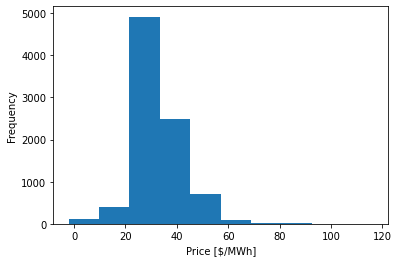

In [4]:
plt.hist(data['Price'])
plt.xlabel("Price [$/MWh]")
plt.ylabel("Frequency")
plt.show()

Finally, let's plot the prices for the first three days in the data set.

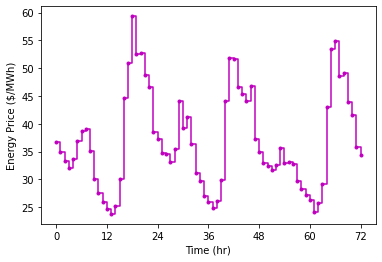

In [5]:
# determine number of hours to plot
nT = 3*24

# determine hour we should start counting
# 0 means start counting at the first hour, i.e., midnight on January 1, 2015
t = 0 + np.arange(nT+1)
price_data = data["Price"][t]

# Make plot.
plt.figure()
plt.step(t,price_data,'m.-',where='post')
plt.xlabel('Time (hr)')
plt.ylabel('Energy Price ($/MWh)')
plt.xticks(range(0,nT+1,12))
plt.show()

## Create Mathematical Model

For simplicity, assume a battery energy storage system is *price-taker*, i.e., they are subject to the market price but their actions do not influence the market price. During each hour $t$, the battery operator decided to either charge (buy energy) or discharge (sell energy) at rates $c_t$ and $d_t$ (units: MW), respectively, subject to the market price $p_t$ (units: \$/MWh).

Assume the battery has a round trip efficiency of $\eta = 88\%$. Let $E_t$ represent the state-of-charge at time $t$ (units: MW). 

![](https://ndcbe.github.io/data-and-computing/_images/battery2.png)

<div class="admonition note"> 
<p class="title"><b>Class Activity</b></p>
 Using the picture above, sketch the battery system. Label $d_t$, $c_t$, $E_t$, and $p_t$ on your sketch. Verify the units are consistent.
</div>

We can now write a constrained optimization problem to compute the optimal market participation strategy (when to buy and sell).

\begin{align*}
    \max_{E,d,c} \quad & \psi := \sum_{t = 1}^{N} p_{t} (d_{t} - c_{t}) \\
\mathrm{s.t.} \quad & E_{t} = E_{t-1} + c_{t} \sqrt{\eta} - \frac{d_{t}}{\sqrt{\eta}}, ~~ \forall ~ t \in \{1,...,N\} \\
    & 0 \leq c_{t} \leq c_{max}, ~~ 0 \leq d_{t} \leq d_{max}, \nonumber \\
    & 0 \leq E_{t} \leq E_{max},  ~~\forall ~ t \in \{1,...,N\}
\end{align*}

<div class="admonition note"> 
<p class="title"><b>Class Activity</b></p>
 Discuss the optimization problem above with a partner. Then, write a few sentences to explain each equation.
</div>

## Define Pyomo Model

We can now write the optimization problem in Pyomo. We will create a set `TIME` to write the model compactly. For a review on creating concrete models, refer to the previous notebook (01-Pyomo-Basics).

<div class="admonition note"> 
<p class="title"><b>Class Activity</b></p>
 Finish the Pyomo model below.
</div>

In [6]:
# define a function to build model
def build_model(price,e0 = 0):
    '''
    Create optimization model for battery operation

    Inputs:
        price: Pandas DataFrame with energy price timeseries
        e0: initial value for energy storage level
    
    Output:
        model: Pyomo optimization model
    '''
    
    # Create a concrete Pyomo model.
    model = ConcreteModel()

    ## Define Sets

    # Number of timesteps in planning horizon
    model.TIME = Set(initialize = price.index)

    ## Define Parameters

    # Square root of round trip efficiency
    model.sqrteta = Param(initialize = sqrt(0.88))

    # Energy in battery at t=0
    model.E0 = Param(initialize = e0, mutable=True)

    # Charging rate [MW]
    model.c = Var(model.TIME, initialize = 0.0, bounds=(0, 1))

    # Add your solution here
    
    ## Define constraints
    
    # Define Energy Balance constraints. [MWh] = [MW]*[1 hr]
    # Note: this model assumes 1-hour timestep in price data and control actions.
    def EnergyBalance(model,t):
        # First timestep
        if t == 0 :
            return model.E[t] == model.E0 + model.c[t]*model.sqrteta-model.d[t]/model.sqrteta 
        
        # Subsequent timesteps
        else :
            # Add your solution here
    
    model.EnergyBalance_Con = Constraint(model.TIME, rule = EnergyBalance)
    
    ## Define the objective function (profit)
    # Receding horizon
    def objfun(model):
        return  sum((-model.c[t] + model.d[t]) * price[t] for t in model.TIME)
    model.OBJ = Objective(rule = objfun, sense = maximize)
    
    return model

## Solve Optimization Model

We can now create an instance of our Pyomo model. Notice the function `build_model` requires we pass in a Pandas DataFrame with the price data. Let's try the first day only.

In [7]:
# Build the model
instance = build_model(data["Price"][0:24],0.0)

# Specify the solver
solver = SolverFactory('ipopt')

# Solve the model
results = solver.solve(instance, tee = True)

Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:       95
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:       72
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       72


## Extract Solution from Pyomo

Excellent. Ipopt terminated with the message `Optimal Solution Found`. Let's inspect the answer.

<div class="admonition note"> 
<p class="title"><b>Class Activity</b></p>
 Run the code below.
</div>

In [8]:
# Declare empty lists
c_control = []
d_control = []
E_control = []
time = []

# Loop over elements of TIME set.
for i in instance.TIME:    
    # Record the time
    time.append(value(i))
    
    # Use value( ) function to extract the solution for each variable and append to the results lists
    c_control.append(value(instance.c[i]))
    
    # Adding negative sign to discharge for plotting
    d_control.append(-value(instance.d[i]))
    E_control.append(value(instance.E[i]))

## Plot Results

Now let's plot the optimal charge and discharge profile.

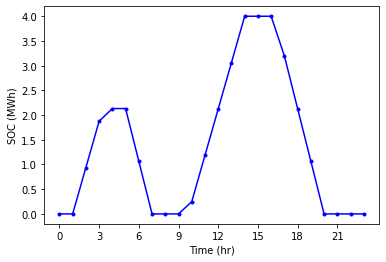

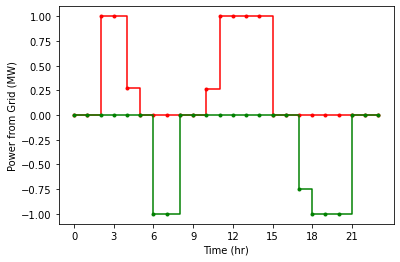

In [9]:
# Plot the state of charge (E)
plt.figure()
plt.plot(time,E_control,'b.-')
plt.xlabel('Time (hr)')
plt.ylabel('SOC (MWh)')
plt.xticks(range(0,24,3))
plt.show()

# Plot the charging and discharging rates 
# we can do a step/stair plot as the control values are constant across each hr
plt.figure()
plt.step(time,c_control,'r.-',where="post")
plt.step(time,d_control,'g.-',where="post")
plt.xlabel('Time (hr)')
plt.ylabel('Power from Grid (MW)')
plt.xticks(range(0,24,3))
plt.show()


## How much money can a 4 MWh battery make in a year?

<div class="admonition note"> 
<p class="title"><b>Class Activity</b></p>
 Copy the code from the cell below the heading <b> Solve Optimization Model </b> to the cell below. Then modify to calculate the revenue for an entire year. Hint: Do NOT modify the function `create_model`.
</div>

In [10]:
# Add your solution here


Ipopt 3.11.1: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

NOTE: You are using Ipopt by default with the MUMPS linear solver.
      Other linear solvers might be more efficient (see Ipopt documentation).


This is Ipopt version 3.11.1, running with linear solver mumps.

Number of nonzeros in equality constraint Jacobian...:    35039
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:    26280
                     variables with only lower bounds:        0
                variables with lower and upper bounds:    26280
